In [1]:
# ============================================
#  PARTIE 0 : IMPORTATION DES LIBRAIRIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [4]:
# ============================================
#  PARTIE 1 : PREPROCESSING
# ============================================

# --- Chargement du dataset ---
df = pd.read_csv("/content/drive/MyDrive/Credit Scoring Bank/bank.csv", sep=';')

print("Aperçu des données :")
display(df.head())

# --- 1.1 Nettoyage : Gestion des doublons ---
df = df.drop_duplicates()

# --- 1.2 Imputation des valeurs manquantes ---
# Stratégie avancée : Imputation différente selon le type
numeric_features = df.select_dtypes(include=np.number).columns
categorical_features = df.select_dtypes(include="object").columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Aperçu des données :


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


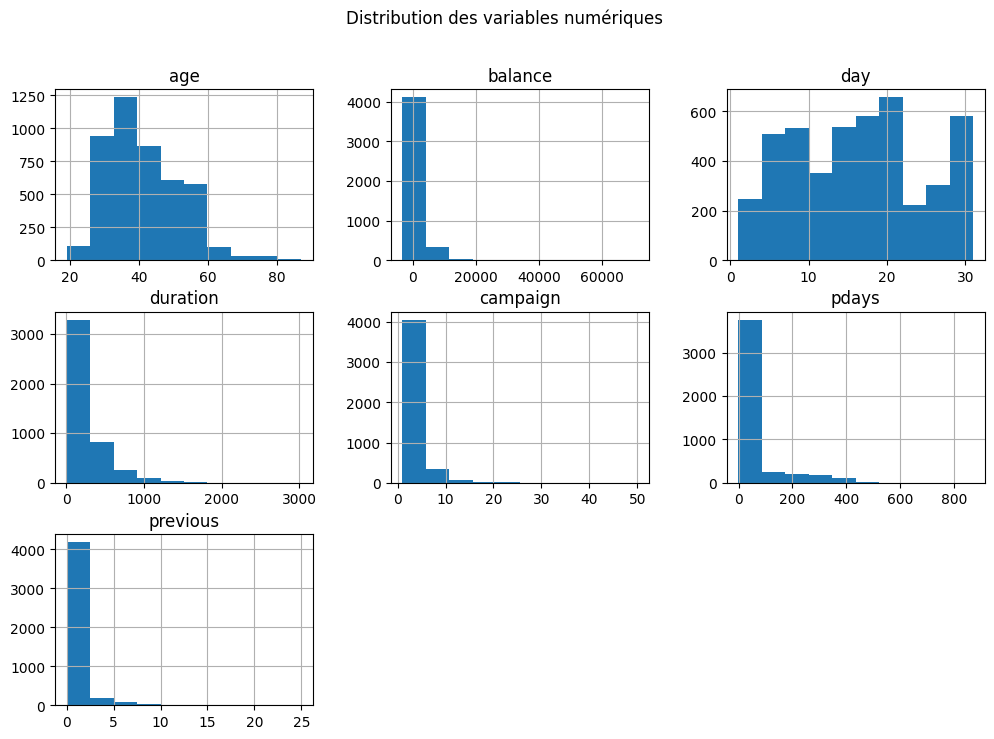

In [5]:
# ============================================
#  PARTIE 2 : EDA
# ============================================

# --- Histogrammes ---
df[numeric_features].hist(figsize=(12, 8))
plt.suptitle("Distribution des variables numériques")
plt.show()


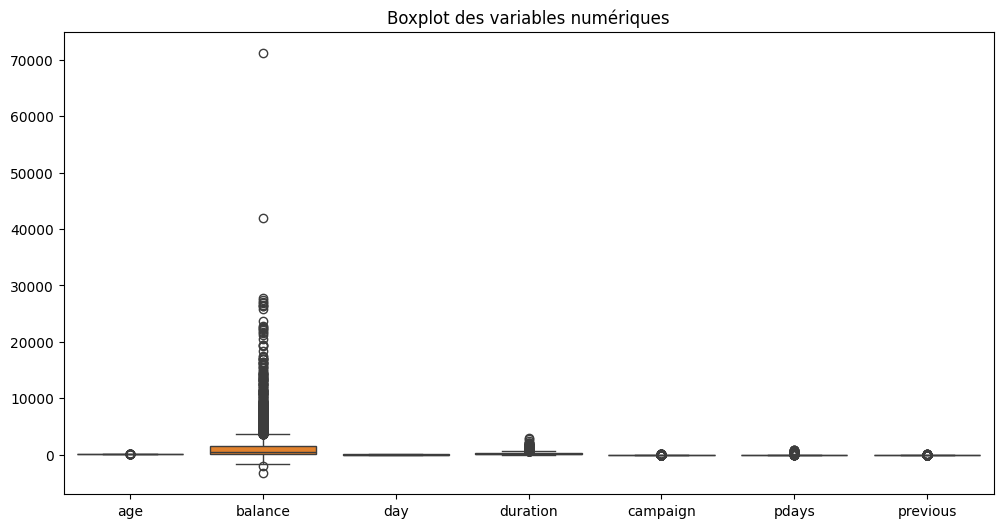

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features])
plt.title("Boxplot des variables numériques")
plt.show()


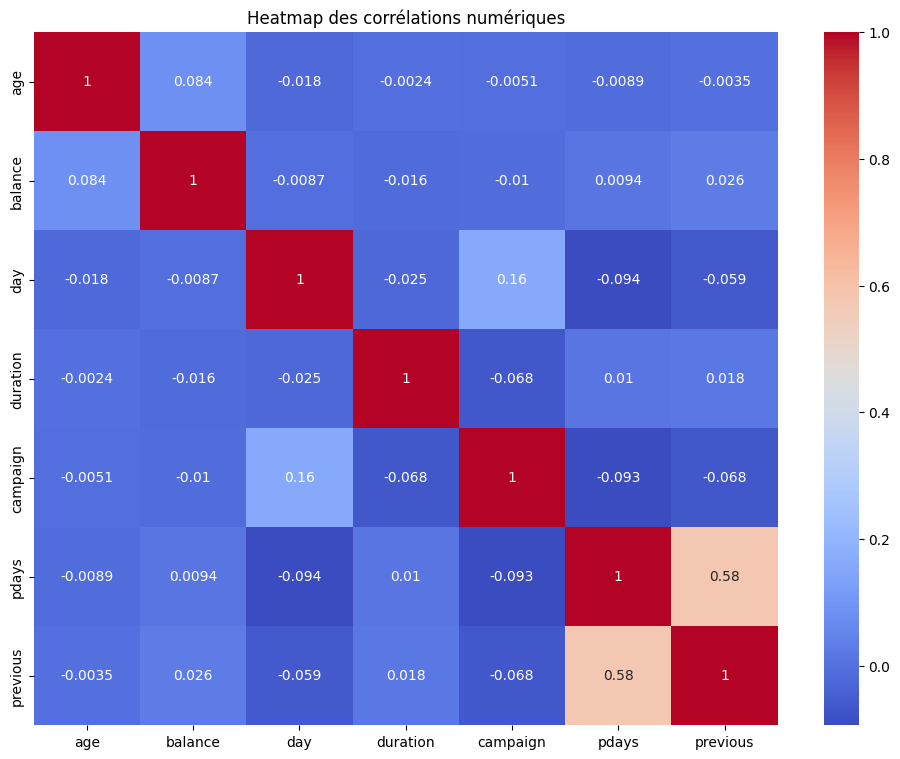

In [7]:
plt.figure(figsize=(12, 9))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap des corrélations numériques")
plt.show()


In [8]:
# Variable d'interaction
df["age_job"] = df["age"] * (df["job"].astype("category").cat.codes + 1)

# Catégorisation
df["age_group"] = pd.cut(df["age"],
                         bins=[18, 30, 45, 60, 100],
                         labels=["Jeune", "Actif", "Mature", "Senior"])


In [9]:
X = df.drop("y", axis=1)
y = df["y"]

# Encodage binaire de la cible
le = LabelEncoder()
y = le.fit_transform(y)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
# Définition des modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

# --- FIX: Redefine preprocessor based on X_train columns to avoid KeyError 'y' ---
# The original preprocessor was defined using 'df' which included 'y'.
# 'X_train' does not include 'y', causing a KeyError.
# Also, new features 'age_job' and 'age_group' were added to 'df' (and thus 'X_train')
# after the original preprocessor was defined.
# We need to redefine the feature lists based on X_train.

# Recalculate numeric_features and categorical_features from X_train
current_numeric_features = X_train.select_dtypes(include=np.number).columns
current_categorical_features = X_train.select_dtypes(include="object").columns

# Redefine preprocessor using the updated feature lists
# The numeric_transformer and categorical_transformer pipelines are already defined and correct.
new_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, current_numeric_features),
        ("cat", categorical_transformer, current_categorical_features)
    ]
)
# --- END FIX ---


# Evaluation via Cross-Validation
for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", new_preprocessor), # Use new_preprocessor
                         ("model", model)])

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name} | Accuracy CV moyenne : {scores.mean():.4f}")

Logistic Regression | Accuracy CV moyenne : 0.9013
Random Forest | Accuracy CV moyenne : 0.9002
SVM | Accuracy CV moyenne : 0.8988


In [15]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 15]
}

rf_pipeline = Pipeline(steps=[
    ("preprocessor", new_preprocessor), # Use the corrected new_preprocessor
    ("model", RandomForestClassifier())
])

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Score :", grid.best_score_)

Meilleurs paramètres : {'model__max_depth': None, 'model__n_estimators': 100}
Score : 0.9015491927178308


Accuracy : 0.8906077348066298

Classification Report :
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       801
           1       0.56      0.23      0.33       104

    accuracy                           0.89       905
   macro avg       0.73      0.60      0.63       905
weighted avg       0.87      0.89      0.87       905



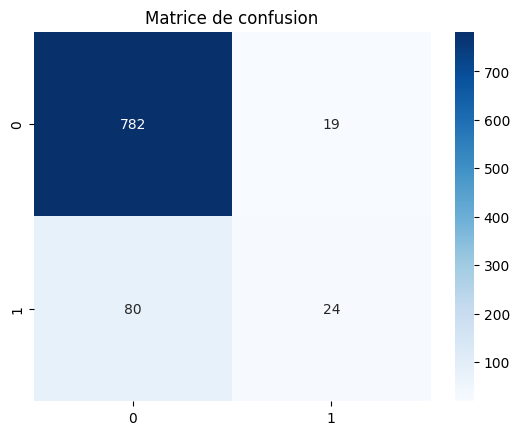

In [16]:
y_pred = grid.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.show()
